In [62]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from imblearn.over_sampling import SMOTE
import sklearn.gaussian_process as gp
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

In [63]:
import tensorflow as tf

In [64]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [65]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')

In [66]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
dataset_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

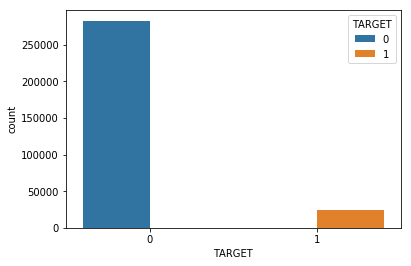

In [68]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train)

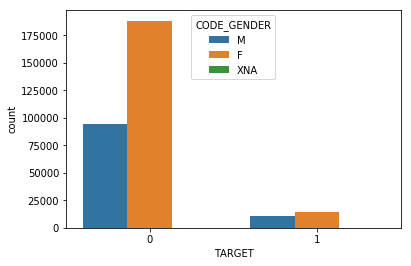

In [70]:
sb.countplot(x='TARGET',hue='CODE_GENDER',data=dataset_train)

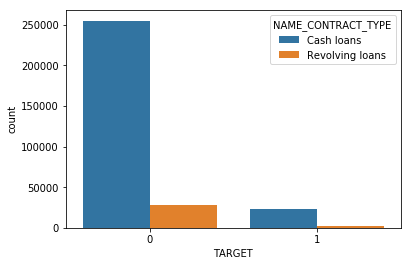

In [71]:
sb.countplot(x='TARGET',hue='NAME_CONTRACT_TYPE',data=dataset_train)

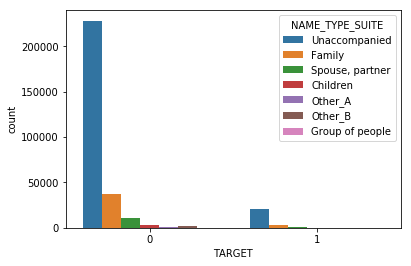

In [72]:
sb.countplot(x='TARGET',hue='NAME_TYPE_SUITE',data=dataset_train)

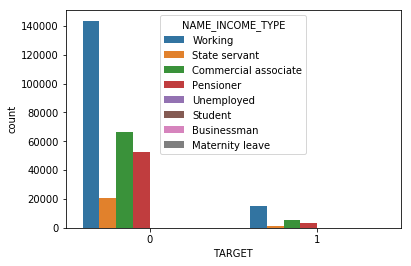

In [73]:
sb.countplot(x='TARGET',hue='NAME_INCOME_TYPE',data=dataset_train)

In [74]:
(dataset_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

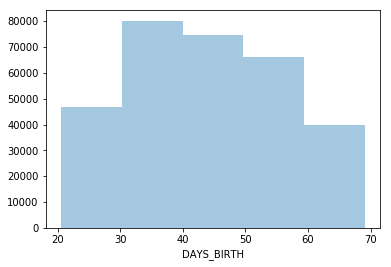

In [75]:
sb.distplot(dataset_train['DAYS_BIRTH']/-365,bins=5,kde=False)

In [76]:
len(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0])


55374

In [77]:
(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0]['TARGET'] == 1).value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

In [78]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [79]:
max(dataset_train['DAYS_EMPLOYED'])

365243

In [80]:
len(dataset_train['DAYS_EMPLOYED'] == 365243)

307511

In [81]:
dataset_train['EMP_AN'] = dataset_train['DAYS_EMPLOYED'] == 365243

In [82]:
dataset_train['DAYS_EMPLOYED'] = dataset_train['DAYS_EMPLOYED'].replace({365243: np.nan})

In [83]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [84]:
(abs(dataset_train['DAYS_REGISTRATION']/365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

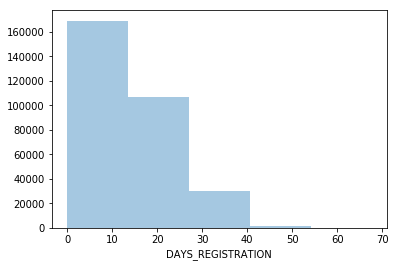

In [85]:
sb.distplot(dataset_train['DAYS_REGISTRATION']/-365,bins=5,kde=False)

In [86]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

80

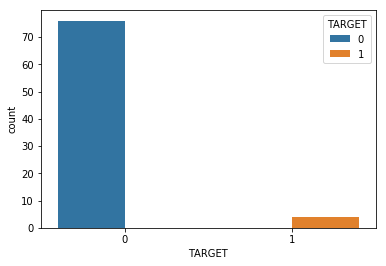

In [87]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50])

In [88]:
dataset_train = dataset_train.drop(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50].index,axis=0)

In [89]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

In [90]:
dataset_train.shape

(307431, 123)

In [91]:
corr = dataset_train.corr(method='pearson')

In [92]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

CNT_CHILDREN - CNT_FAM_MEMBERS
0.8791849055884082
AMT_CREDIT - AMT_ANNUITY
0.7701355325112837
REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9508244177203856
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8606542659268078
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8255558750839367
APARTMENTS_AVG - ELEVATORS_AVG
0.8369526900299763
BASEMENTAREA_AVG - BASEMENTAREA_MODE
0.973496185301789
YEARS_BEGINEXPLUATATION_AVG - YEARS_BEGINEXPLUATATION_MODE
0.97189305389083
YEARS_BUILD_AVG - YEARS_BUILD_MODE
0.9894360514168624
COMMONAREA_AVG - COMMONAREA_MODE
0.9771461116759385
ENTRANCES_AVG - ENTRANCES_MODE
0.9777417653401914
FLOORSMAX_AVG - FLOORSMIN_AVG
0.7424268126795673
LANDAREA_AVG - LANDAREA_MODE
0.9736925929909296
LIVINGAPARTMENTS_AVG - LIVINGAREA_AVG
0.8807913124080583
NONLIVINGAPARTMENTS_AVG - NONLIVINGAPARTMENTS_MODE
0.9693697425066614
NONLIVINGAREA_AVG - NONLIVINGAREA_MODE
0.9660854607189583
APARTMENTS_MODE - ELEVATORS_MODE
0.8262109330460732
FLOORSMAX_MODE - FLOO

In [93]:
#Columnd to remove die to high correlation (Only measured colinearity among pairs of parameters still have to deal
#with multi-colinearity)
columns_to_remove = ['CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_WORK_REGION',
                    'LIVE_CITY_NOT_WORK_CITY','ELEVATORS_AVG','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE','COMMONAREA_MODE','ENTRANCES_MODE','FLOORSMIN_AVG','LANDAREA_MODE',
                    'LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','ELEVATORS_MODE','FLOORSMIN_MODE',
                    'LIVINGAREA_MODE','ELEVATORS_MEDI','FLOORSMIN_MEDI','LIVINGAREA_MEDI','OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE']

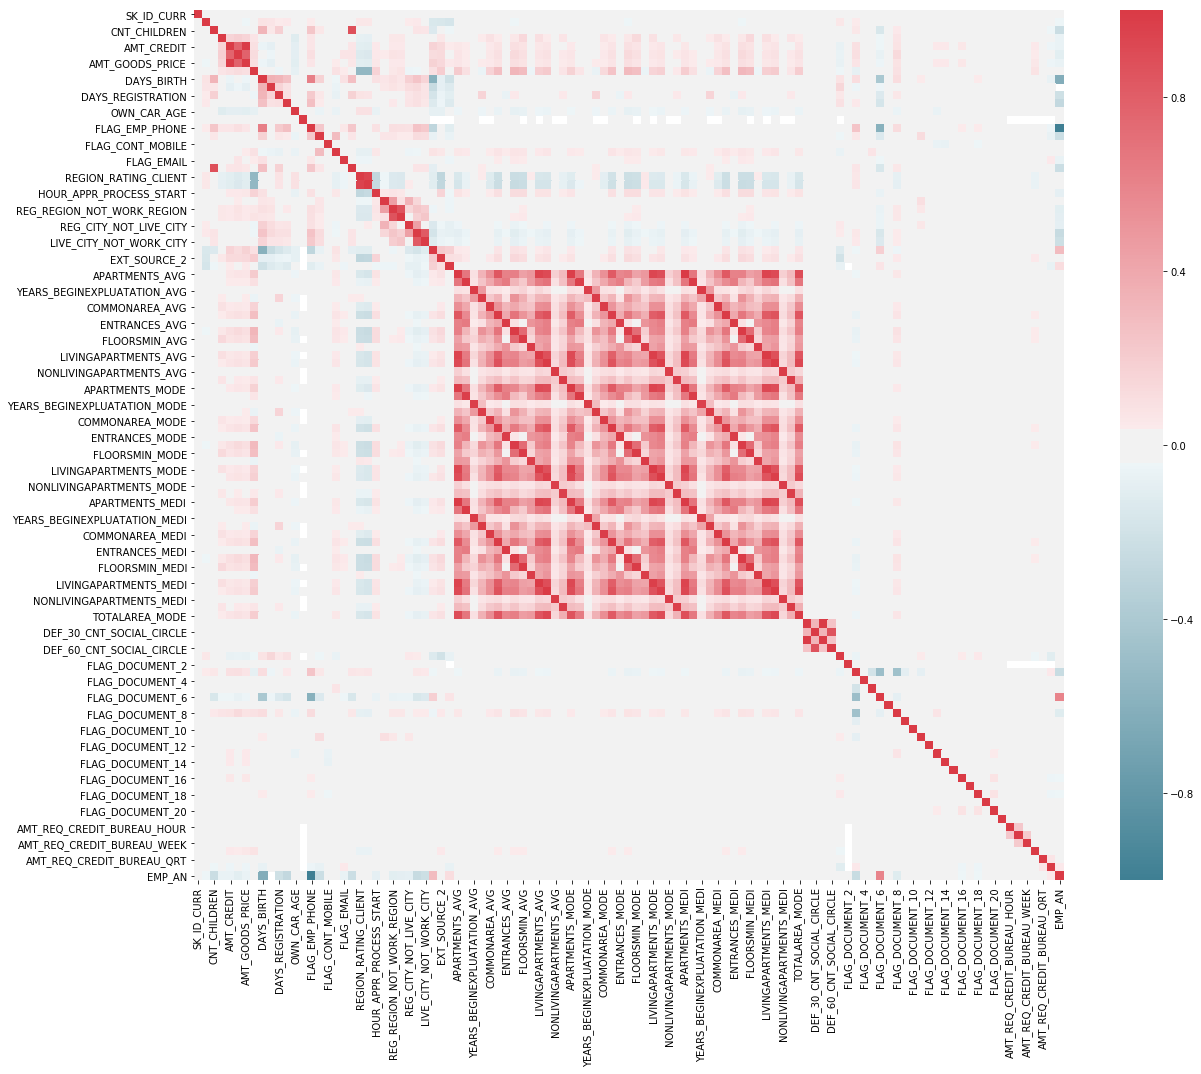

In [94]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [95]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [96]:
dataset_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [97]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    dataset_train[column] = le.fit_transform(dataset_train[column].astype(str))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

Time Elapsed:- 
0.32163190841674805


In [98]:
columns_to_one_hot_encode = ['CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                            'FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','HOUSETYPE_MODE']
starttime = time.time()
for column in columns_to_one_hot_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column].astype(str))
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    df = df.drop([column + "0"],axis=1)
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
dataset_train = dataset_train.drop(columns_to_one_hot_encode,axis=1)
dataset_train.shape

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


CODE_GENDER - 307511 103


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_TYPE_SUITE - 307511 110


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_INCOME_TYPE - 307511 118


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_EDUCATION_TYPE - 307511 123


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_FAMILY_STATUS - 307511 129


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_HOUSING_TYPE - 307511 135


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OCCUPATION_TYPE - 307511 153


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ORGANIZATION_TYPE - 307511 211


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WEEKDAY_APPR_PROCESS_START - 307511 218


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


FONDKAPREMONT_MODE - 307511 222


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WALLSMATERIAL_MODE - 307511 229


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


HOUSETYPE_MODE - 307511 232


(307511, 220)

In [99]:
dataset_train['DIR'] = dataset_train['AMT_CREDIT']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['AIR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['ACR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_CREDIT']
dataset_train['DAR'] = dataset_train['DAYS_EMPLOYED']/dataset_train['DAYS_BIRTH']

In [100]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(40000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [101]:
from sklearn.preprocessing import StandardScaler, Imputer
imputer = Imputer(strategy='median')
scaler = StandardScaler()
dataset_train_tr = imputer.fit_transform(dataset_train.drop(['SK_ID_CURR','TARGET'],axis=1))
dataset_train_tr = scaler.fit_transform(dataset_train_tr)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [102]:
X = dataset_train_tr
y = dataset_train['TARGET']

In [103]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [104]:
X_test = pd.DataFrame(X_test,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))

In [105]:
X_test.shape

(12000, 222)

In [106]:
y_test.shape

(12000,)

In [107]:
#Using SMOTE(Synthetic Minority Oversampling Technique) to handle imbalanced dataset
smote_train = SMOTE(random_state=232)
os_data_X,os_data_y = smote_train.fit_sample(X_train,y_train)
X_train = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']) )
y_train = pd.DataFrame(data=os_data_y,columns=["TARGET"])

In [108]:
X_test.shape

(12000, 222)

In [109]:
y_test.shape

(12000,)

In [110]:
smote_test = SMOTE(random_state=232)
os_data_X,os_data_Y = smote_test.fit_sample(X_test,y_test)
X_test = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))
y_test = pd.DataFrame(data=os_data_Y,columns=['TARGET'])

In [111]:
X_train.shape

(63824, 222)

In [112]:
y_train.shape

(63824, 1)

In [113]:
X_test.shape

(16176, 222)

In [114]:
y_test.shape

(16176, 1)

In [115]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [116]:
X.shape

(60000, 222)

In [117]:
y.shape

(60000,)

In [119]:
X = pd.concat([X_train,X_test],axis=0)
y = pd.concat([y_train,y_test],axis=0)

In [120]:
y_train = np.array(y_train)
y_train = y_train.ravel()

In [121]:
y_test = np.array(y_test)
y_test = y_test.ravel()

In [128]:
y = np.array(y)
y = y.ravel()

In [129]:
def cross_validation_score(model,X,y,cv=5):
    scores = cross_val_score(model,X,y,cv=cv)
    return sum(scores)/len(scores)

In [130]:
#Use k-fold cross validation to generate estimate of test accuracy

In [131]:
clf = LogisticRegression(C=0.4,max_iter = 1000)
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [132]:
prediction = clf.predict(X_test)

In [133]:
accuracy_score(y_test,prediction)

0.7020895153313551

In [134]:
confusion_matrix(y_test,prediction)

array([[5546, 2542],
       [2277, 5811]])

In [135]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

0.6953125

              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70      8088
         1.0       0.70      0.72      0.71      8088

   micro avg       0.70      0.70      0.70     16176
   macro avg       0.70      0.70      0.70     16176
weighted avg       0.70      0.70      0.70     16176



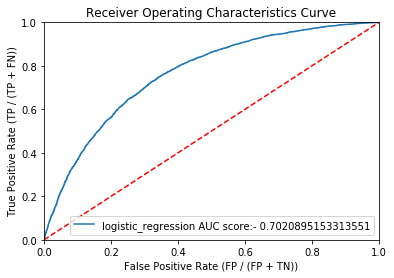

In [136]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

In [137]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [138]:
pred = clf.predict(X_test)

In [139]:
accuracy_score(y_test,pred)

0.7025222551928784

In [140]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.695

              precision    recall  f1-score   support

         0.0       0.71      0.68      0.70      8088
         1.0       0.70      0.72      0.71      8088

   micro avg       0.70      0.70      0.70     16176
   macro avg       0.70      0.70      0.70     16176
weighted avg       0.70      0.70      0.70     16176



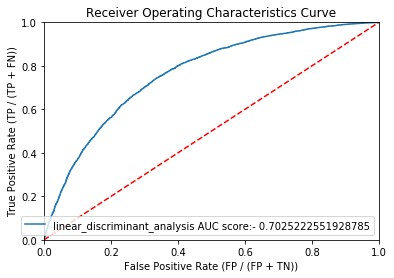

In [141]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],name="linear_discriminant_analysis")

In [142]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [143]:
pred = clf.predict(X_test)

In [144]:
accuracy_score(y_test,pred)

0.5253461918892186

In [145]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Varia

0.5446375000000001

              precision    recall  f1-score   support

         0.0       0.53      0.41      0.46      8088
         1.0       0.52      0.64      0.58      8088

   micro avg       0.53      0.53      0.53     16176
   macro avg       0.53      0.53      0.52     16176
weighted avg       0.53      0.53      0.52     16176



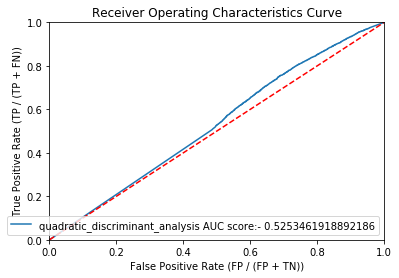

In [146]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],"quadratic_discriminant_analysis")

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 10 trees:- 
2.1480841636657715
Accuracy score for 10 trees:- 
0.7397378832838774
Confusion matrix for 10 trees:- 
[6454 1634 2576 5512]
OOB score for 10 trees:- 
0.7092786412634745
Classifier report for 10 trees:- 
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75      8088
         1.0       0.77      0.68      0.72      8088

   micro avg       0.74      0.74      0.74     16176
   macro avg       0.74      0.74      0.74     16176
weighted avg       0.74      0.74      0.74     16176



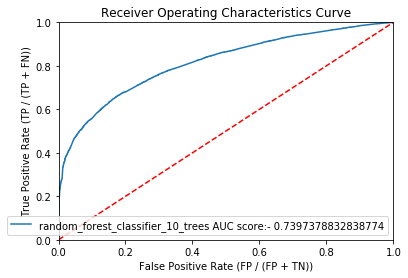

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 20 trees:- 
4.919151067733765
Accuracy score for 20 trees:- 
0.748269040553907
Confusion matrix for 20 trees:- 
[6472 1616 2456 5632]
OOB score for 20 trees:- 
0.7391263474555027
Classifier report for 20 trees:- 
              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76      8088
         1.0       0.78      0.70      0.73      8088

   micro avg       0.75      0.75      0.75     16176
   macro avg       0.75      0.75      0.75     16176
weighted avg       0.75      0.75      0.75     16176



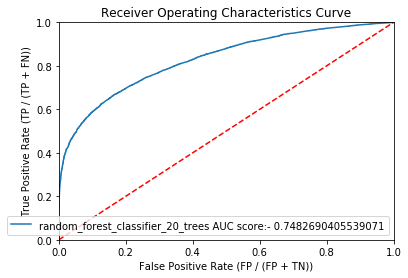

Time to train 30 trees:- 
6.2194812297821045
Accuracy score for 30 trees:- 
0.7654549950544016
Confusion matrix for 30 trees:- 
[6662 1426 2368 5720]
OOB score for 30 trees:- 
0.7567529456004011
Classifier report for 30 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78      8088
         1.0       0.80      0.71      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.77      0.77      0.76     16176
weighted avg       0.77      0.77      0.76     16176



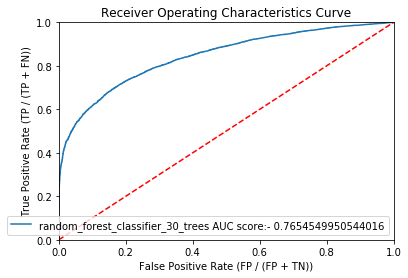

Time to train 40 trees:- 
8.643979787826538
Accuracy score for 40 trees:- 
0.7662586547972304
Confusion matrix for 40 trees:- 
[6692 1396 2385 5703]
OOB score for 40 trees:- 
0.7667335171722236
Classifier report for 40 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78      8088
         1.0       0.80      0.71      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.77      0.77      0.77     16176
weighted avg       0.77      0.77      0.77     16176



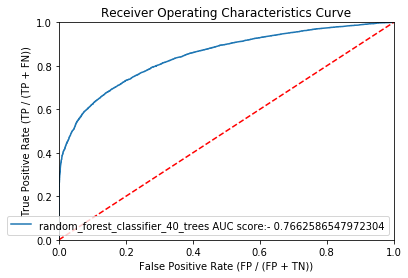

Time to train 50 trees:- 
10.087653875350952
Accuracy score for 50 trees:- 
0.7684841740850643
Confusion matrix for 50 trees:- 
[6714 1374 2371 5717]
OOB score for 50 trees:- 
0.7711519177738781
Classifier report for 50 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78      8088
         1.0       0.81      0.71      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.77      0.77      0.77     16176
weighted avg       0.77      0.77      0.77     16176



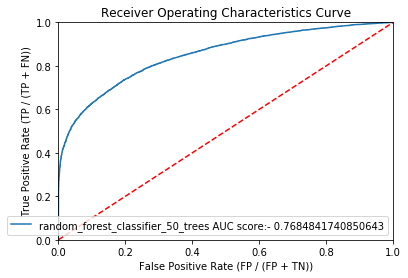

Time to train 100 trees:- 
22.126632928848267
Accuracy score for 100 trees:- 
0.7738006923837785
Confusion matrix for 100 trees:- 
[6786 1302 2357 5731]
OOB score for 100 trees:- 
0.785237528202557
Classifier report for 100 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      8088
         1.0       0.81      0.71      0.76      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.78      0.77      0.77     16176
weighted avg       0.78      0.77      0.77     16176



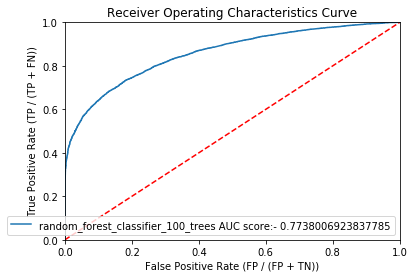

Time to train 150 trees:- 
31.692087650299072
Accuracy score for 150 trees:- 
0.7763353115727003
Confusion matrix for 150 trees:- 
[6821 1267 2351 5737]
OOB score for 150 trees:- 
0.7891075457508148
Classifier report for 150 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



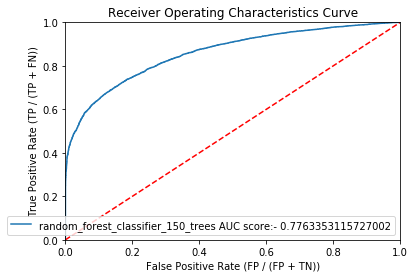

Time to train 200 trees:- 
39.39320111274719
Accuracy score for 200 trees:- 
0.7794263105835806
Confusion matrix for 200 trees:- 
[6848 1240 2328 5760]
OOB score for 200 trees:- 
0.7922254951115568
Classifier report for 200 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



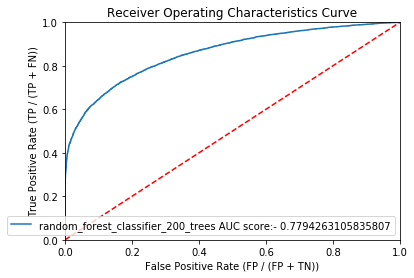

Time to train 250 trees:- 
54.76235318183899
Accuracy score for 250 trees:- 
0.7751607319485658
Confusion matrix for 250 trees:- 
[6814 1274 2363 5725]
OOB score for 250 trees:- 
0.7927268739032339
Classifier report for 250 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.77     16176
weighted avg       0.78      0.78      0.77     16176



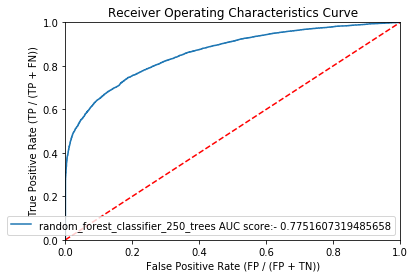

Time to train 300 trees:- 
70.21662187576294
Accuracy score for 300 trees:- 
0.7776335311572701
Confusion matrix for 300 trees:- 
[6854 1234 2363 5725]
OOB score for 300 trees:- 
0.7940586613186262
Classifier report for 300 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



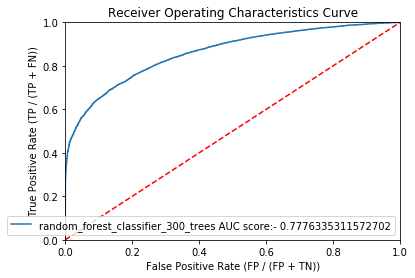

Time to train 400 trees:- 
80.69167304039001
Accuracy score for 400 trees:- 
0.7789317507418397
Confusion matrix for 400 trees:- 
[6863 1225 2351 5737]
OOB score for 400 trees:- 
0.7935886187014289
Classifier report for 400 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



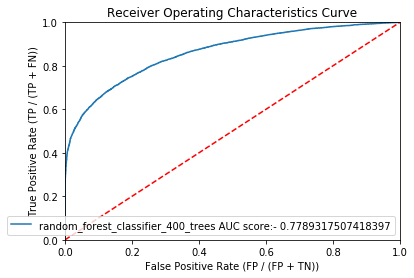

Time to train 500 trees:- 
103.30131673812866
Accuracy score for 500 trees:- 
0.7817754698318496
Confusion matrix for 500 trees:- 
[6887 1201 2329 5759]
OOB score for 500 trees:- 
0.7958761594384558
Classifier report for 500 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80      8088
         1.0       0.83      0.71      0.77      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



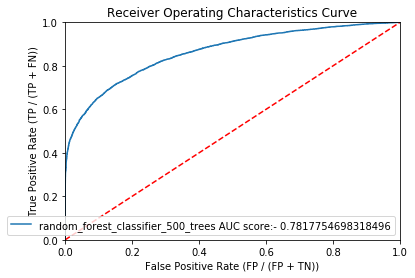

Time to train 750 trees:- 
146.10744881629944
Accuracy score for 750 trees:- 
0.7815281899109793
Confusion matrix for 750 trees:- 
[6897 1191 2343 5745]
OOB score for 750 trees:- 
0.7963462020556531
Classifier report for 750 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



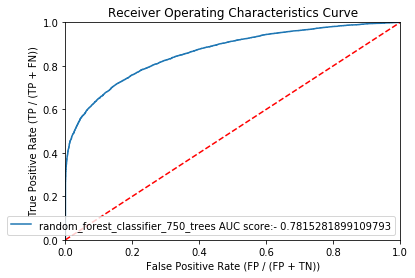

Time to train 1000 trees:- 
204.96030282974243
Accuracy score for 1000 trees:- 
0.7802299703264095
Confusion matrix for 1000 trees:- 
[6880 1208 2347 5741]
OOB score for 1000 trees:- 
0.7964872148408122
Classifier report for 1000 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



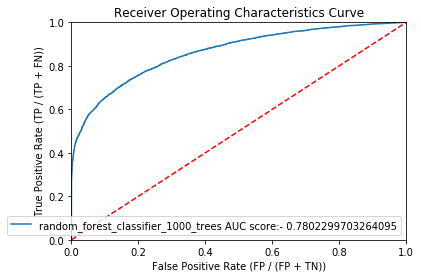

In [147]:
#Have to use Bayesian Optimization to find better set of hyperparameters
#performant value found 400
no_of_trees = [10,20,30,40,50,100,150,200,250,300,400,500,750,1000]
error = []
for noft in no_of_trees:
    starttime = time.time()
    classifier = RandomForestClassifier(n_estimators=noft,max_depth=25,oob_score=True)
    classifier.fit(X_train,y_train)
    endtime = time.time()
    print("Time to train " + str(noft) + " trees:- ")
    print(endtime - starttime)
    error.append(classifier.oob_score_)
    prediction = classifier.predict(X_test)
    print("Accuracy score for " + str(noft) + " trees:- ")
    print(accuracy_score(y_test,prediction))
    print("Confusion matrix for " + str(noft) + " trees:- ")
    print(confusion_matrix(y_test,prediction).ravel())
    print("OOB score for " + str(noft) + " trees:- ")
    print(classifier.oob_score_)
    print("Classifier report for " + str(noft) + " trees:- ")
    generate_classifier_report(classifier,prediction,classifier.predict_proba(X_test)[:,1],"random_forest_classifier_" + str(noft) + "_trees")

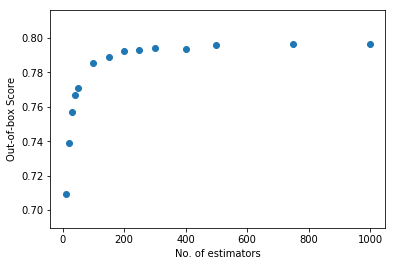

In [148]:
plt.scatter(no_of_trees,error)
plt.xlabel("No. of estimators")
plt.ylabel("Out-of-box Score")
plt.savefig("error_vs_nestimators.jpg")

In [149]:
starttime = time.time()
boosting = XGBClassifier(alpha=1,eval_metric='logloss',max_depth=25,n_estimators=400,verbosity=2)
boosting.fit(X_train,y_train)
endtime = time.time()
print("Time to train XGBClassifier :- ")
print(endtime - starttime)

Time to train XGBClassifier :- 
997.1159100532532


In [150]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

0.7941394658753709

In [151]:
confusion_matrix(y_test,pred)

array([[6899, 1189],
       [2141, 5947]])

In [152]:
cross_validation_score(boosting,X,y,cv=5)

0.7746000000000001

              precision    recall  f1-score   support

         0.0       0.76      0.85      0.81      8088
         1.0       0.83      0.74      0.78      8088

   micro avg       0.79      0.79      0.79     16176
   macro avg       0.80      0.79      0.79     16176
weighted avg       0.80      0.79      0.79     16176



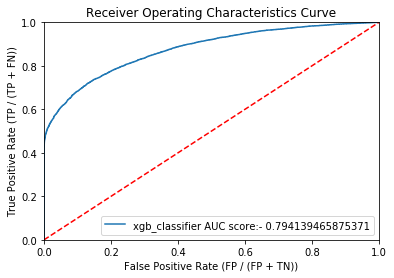

In [153]:
generate_classifier_report(boosting,pred,boosting.predict_proba(X_test)[:,1],'xgb_classifier')

In [154]:
starttime = time.time()
clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=400,max_depth=25)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train LightGBM classifier:- ")
print(endtime - starttime)

Time to train LightGBM classifier:- 
33.68696713447571


In [155]:
pref = clf.predict(X_test)
accuracy_score(y_test,pred)

0.7941394658753709

In [156]:
confusion_matrix(y_test,pred)

array([[6899, 1189],
       [2141, 5947]])

In [157]:
cross_validation_score(clf,X,y,cv=5)

0.7735375

              precision    recall  f1-score   support

         0.0       0.76      0.85      0.81      8088
         1.0       0.83      0.74      0.78      8088

   micro avg       0.79      0.79      0.79     16176
   macro avg       0.80      0.79      0.79     16176
weighted avg       0.80      0.79      0.79     16176



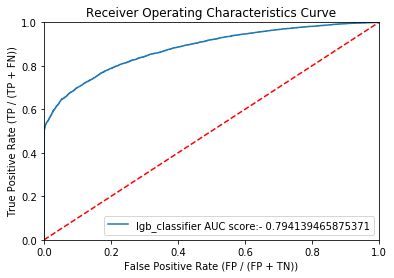

In [158]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],'lgb_classifier')

In [ ]:
X = tf.placeholder(shape=[None,222],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int64)

In [ ]:
weights = {
    'W1': tf.Variable(tf.truncated_normal(shape=[222,140])),
    'W2': tf.Variable(tf.truncated_normal(shape=[140,70])),
    'W3': tf.Variable(tf.truncated_normal(shape=[70,27])),
    'W4': tf.Variable(tf.truncated_normal(shape=[27,1]))
}
biases = {
    'b1': tf.Variable(tf.truncated_normal(shape=[140])),
    'b2': tf.Variable(tf.truncated_normal(shape=[70])),
    'b3': tf.Variable(tf.truncated_normal(shape=[27])),
    'b4': tf.Variable(tf.truncated_normal(shape=[1]))
}

In [ ]:
def get_model(X,weights,biases):
    op1 = tf.add(tf.matmul(X,weights['W1']),biases['b1'])
    relu_op1 = tf.nn.relu(op1) 
    op2 = tf.add(tf.matmul(relu_op1,weights['W2']),biases['b2'])
    relu_op2 = tf.nn.relu(op2)
    op3 = tf.add(tf.matmul(relu_op2,weights['W3']),biases['b3'])
    relu_op3 = tf.nn.relu(op3)
    op4 = tf.add(tf.matmul(relu_op3,weights['W4']),biases['b4'])
    return op4

In [ ]:
pred = get_model(X,weights,biases)
optimizer = tf.train.AdamOptimizer(learning_rate=0.)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_step = optimizer.minimize(loss)

In [ ]:
#Improve accuracy here 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0,10):
        cost = 0
        total_batch = X_train.shape[0]/100
        X_batches = np.array_split(X_train,total_batch)
        y_batches = np.array_split(y_train,total_batch)
        for j in range(0,int(total_batch)):
            g,c = sess.run([train_step,loss],feed_dict={
                X: X_batches[j],
                y: y_batches[j]
            })
            cost = cost + c/total_batch
        print("Epoch:- " + str(i) + " Cost:- " + str(cost))
    correct_prediction = tf.equal(tf.argmax(pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    print("Accuracy:- " + str(accuracy.eval({X: X_test,y: y_test})))

In [ ]:
starttime = time.time()
clf = SVC(gamma=0.001, C=1.0)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train SVC classifier:- ")
print(endtime - starttime)

In [ ]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

In [ ]:
confusion_matrix(y_test,pred).ravel()